In [168]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import json

In [88]:
M = 300 #number of random walkers
R = np.zeros((2*M,3))
for m in range(2*M):
    for d in range(3):
        R[m,d] = np.random.uniform(-0.5, 0.5)

In [278]:
def psi_T(vec_r_1, vec_r_2, alpha, kappa, beta):
    r_1 = np.linalg.norm(vec_r_1)
    r_2 = np.linalg.norm(vec_r_2)
    vec_r12 = vec_r_1 - vec_r_2
    r_12 = np.linalg.norm(vec_r12)
    pref = beta*r_12/(1+alpha*r_12)
    psi = np.exp(-kappa*r_1)*np.exp(-kappa*r_2)*np.exp(pref)
    return psi

def Fokker_planck(vec_r_1, vec_r_2, alpha, kappa, beta):
    r_1 = np.linalg.norm(vec_r_1)
    #r_2 = np.linalg.norm(vec_r_2)
    vec_r12 = vec_r_2 - vec_r_1
    r_12 = np.linalg.norm(vec_r12)
    u = 1 + alpha*r_12
    factor = beta*(((u/r_12)-alpha)/u**2)
    force_1 = 2*(-kappa*(vec_r_1/r_1)+factor*(vec_r_1-vec_r_2))
    #force_2 = 2*(-kappa*(vec_r_2/r_2)+factor*(vec_r_2-vec_r_1))
    return np.array(force_1)

def greens_function(vec_r_try_1, vec_r_try_2, vec_r_old_1, vec_r_old_2, alpha, beta, kappa, delta_t):    
    f1 = Fokker_planck(vec_r_try_1, vec_r_try_2, alpha, kappa, beta)
    f2 = Fokker_planck(vec_r_old_1, vec_r_old_2, alpha, kappa, beta)
    
    norm_diff_1 = np.linalg.norm(vec_r_try_1 - vec_r_old_1)
    norm_diff_2 = np.linalg.norm(vec_r_try_2 - vec_r_old_2)
    
    return (1/np.sqrt(2*np.pi*delta_t)) * np.exp(-norm_diff**2 / (4*gamma*delta_t))

def metropolis_algorithm(initial_state, num_trials, s, alpha, beta, kappa, use_FP = False, delta_t=1, disable_tqdm = False):
    sequence_states = [initial_state]
    list_probs = []
    for _ in tqdm(range(num_trials), disable=disable_tqdm):
        next_sequence, prob = metropolis_step(sequence_states[-1], alpha, beta, s, kappa, delta_t=delta_t, use_FP=use_FP)
        sequence_states.append(next_sequence)
        list_probs.append(prob)
    return np.array(sequence_states), list_probs
   
def metropolis_step(current_state, alpha, beta, s, kappa, delta_t = 1, use_FP=False):
    trial_configuration = current_state.copy()
    #new_state = np.zeros(current_state.shape)
    for i in range(M):
        which_particle = np.random.choice([0,M])
        if use_FP:
            trial_configuration[i+which_particle] += Fokker_planck(current_state[i+which_particle], current_state[i+M-which_particle], alpha, kappa, beta)*delta_t/2 #Todo: Is this correct?
        trial_configuration[i+which_particle] += np.random.uniform(low=-s/2, high=s/2, size=3)*np.sqrt(delta_t)
        p = psi_T(trial_configuration[i], trial_configuration[i+M], alpha, kappa, beta)**2 / psi_T(current_state[i], current_state[i+M], alpha, kappa, beta)**2
        if use_FP:
            g1 = greens_function(trial_configuration[i], current_state[i], alpha, beta, kappa, delta_t)*greens_function(trial_configuration[i+M], current_state[i+M], alpha, beta, kappa, delta_t)
            g2 = greens_function(trial_configuration[i], current_state[i], alpha, beta, kappa, delta_t)*greens_function(trial_configuration[i+M], current_state[i+M], alpha, beta, kappa, delta_t)
            p *= g1/g2                    
        trial_acceptance_prob = p
        r_accept = np.random.rand()
        if r_accept < trial_acceptance_prob:
            new_state[i] = trial_configuration[i]
            new_state[i+M] = trial_configuration[i+M]
        else:
            new_state[i] = current_state[i]
            new_state[i+M] = current_state[i+M]
    return np.array(new_state), p

In [279]:
alpha = 0.15
beta = 0.5
kappa = 2
print(R[0])
R_trial = R[0] + np.random.uniform(low=-1/2, high=1/2, size=3)
R_trial_2 = R[M] + np.random.uniform(low=-1/2, high=1/2, size=3)
print(R_trial)
print((psi_T(R_trial, R_trial_2, alpha, kappa, beta)/psi_T(R[0], R[M], alpha, kappa, beta))**2)

[ 0.14800474 -0.1641085   0.28298481]
[-0.12494139 -0.22007364 -0.21635995]
0.9714833264481171


In [294]:
def energy_local(vec_r_1, vec_r_2, alpha, beta, kappa):
    r_1 = np.linalg.norm(vec_r_1)
    r_2 = np.linalg.norm(vec_r_2)
    vec_r12 = vec_r_1 - vec_r_2
    r_12 = np.linalg.norm(vec_r12)
    u = 1+alpha*r_12
    scalar_product = np.dot((vec_r_1/r_1) - (vec_r_2/r_2), vec_r12/r_12)
    
    term_1 = (kappa-2)/r_1
    term_2 = (kappa-2)/r_2
    term_3 = (1-2*beta/u**2)/r_12
    term_4 = 2*beta*alpha/u**3
    term_5 = -kappa**2
    term_6 = -(beta**2)/u**4
    term_7 = (kappa*beta/u**2)*scalar_product
    E_L =  term_1 + term_2 + term_3 + term_4 + term_5 + term_6 + term_7    
    return E_L

def energy_statistics(simulation, accumulate_last_n, alpha, beta, kappa, disable_tqdm = False):
    energies = []
    num_simulation_steps = simulation.shape[0]
    e_0 = [energy_local(simulation[0,i], simulation[0,i+M], alpha=alpha, beta=beta, kappa=kappa) for i in range(M)]
    e_avg_accumulated = [np.mean(e_0)]
    e_var_accumulated = [np.std(e_0)]
    for time in tqdm(range(1, num_simulation_steps), disable=disable_tqdm):
        e_t = []
        for i in range(M):
            e_i = energy_local(simulation[time,i], simulation[time,i+M], alpha=alpha, beta=beta, kappa=kappa)
            e_t.append(e_i)
        energies.append(e_t)
    for time in range(1, num_simulation_steps, accumulate_last_n):
        if time > accumulate_last_n:
            e_avg_t = np.mean(energies[time-accumulate_last_n:time])
            e_var_t = np.std(energies[time-accumulate_last_n:time])
        else: #For the first 999 time steps:
            e_avg_t = np.mean(energies[:time])
            e_var_t = np.std(energies[:time])            
        e_avg_accumulated.append(e_avg_t)
        e_var_accumulated.append(e_var_t)
    return np.array(e_avg_accumulated), np.sqrt(1/M)*np.array(e_var_accumulated)

In [295]:
sim, probs = metropolis_algorithm(R, num_trials=10000, s=1, alpha=0.15, beta=0.5, kappa=2)
E_avg_s, E_std_s = energy_statistics(sim, 1000, alpha=0.15, beta=0.5, kappa=2)

100%|██████████| 10000/10000 [00:33<00:00, 294.79it/s]


In [271]:
sim.shape

(10001, 600, 3)

In [288]:
sim_new.shape

(100, 600, 3)

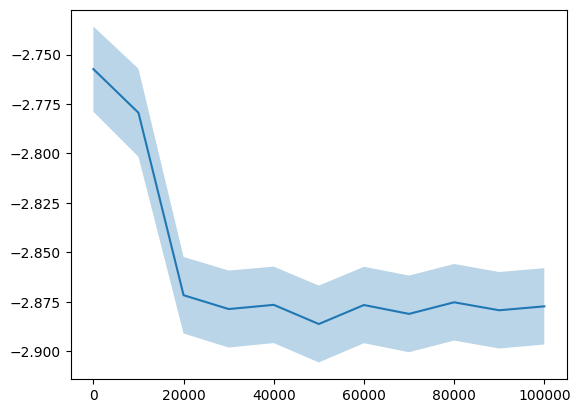

In [297]:
plt.plot(np.arange(E_avg_s.shape[0])*10000, E_avg_s)
plt.fill_between(np.arange(E_avg_s.shape[0])*10000, E_avg_s-E_std_s, E_avg_s+E_std_s, alpha=0.3)

In [267]:
list_1 = []
list_2 = []
list_3 = []

for i in range(M):
    r1 = np.linalg.norm(sim[-1, i])
    r2 = np.linalg.norm(sim[-1, i+M])
    r12 = np.linalg.norm(sim[-1, i]-sim[-1, i+M])
    list_1.append(r1)
    list_2.append(r2)
    list_3.append(r12)

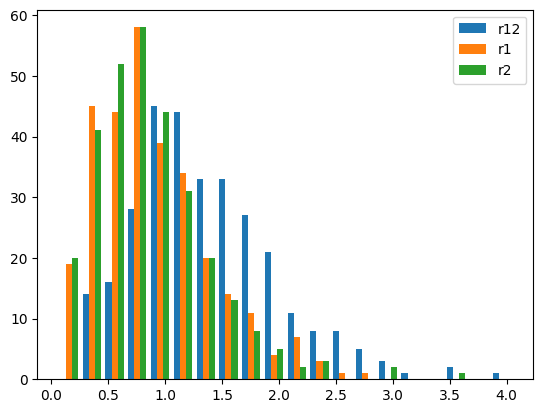

In [268]:
plt.hist([list_3,list_1,list_2], bins=20, label=["r12", "r1","r2"])
plt.legend()

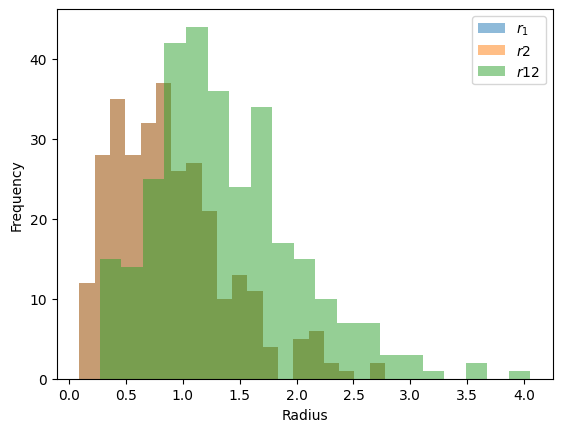

In [263]:
l1 = list_1
l2 = list_2
l12 = list_3
plt.hist(l1, bins=20, alpha=0.5, label='$r_1$')
plt.hist(l2, bins=20, alpha=0.5, label='$r2$')
plt.hist(l12, bins=20, alpha=0.5, label='$r{12}$')
plt.xlabel('Radius')
plt.ylabel('Frequency')
plt.legend()

In [250]:
#walker = np.random.randint(0,300)
zeitpunkt = -2
np.mean([energy_local(sim[zeitpunkt,walker], sim[zeitpunkt,walker+M], 0.15, 0.5, 2) for walker in range(M)])

-2.836092826162541

(array([0.09360796, 0.62613322, 1.06505053, 1.34795457, 1.34379422,
        1.15033778, 1.08793247, 1.02344699, 0.88199497, 0.79462754,
        0.70517994, 0.68853852, 0.57204862, 0.58036933, 0.43683713,
        0.43891731, 0.44515784, 0.3681913 , 0.39523359, 6.75641429]),
 array([0.03854327, 0.0866161 , 0.13468894, 0.18276178, 0.23083461,
        0.27890745, 0.32698029, 0.37505312, 0.42312596, 0.4711988 ,
        0.51927163, 0.56734447, 0.61541731, 0.66349014, 0.71156298,
        0.75963582, 0.80770865, 0.85578149, 0.90385433, 0.95192716,
        1.        ]),
 <BarContainer object of 20 artists>)

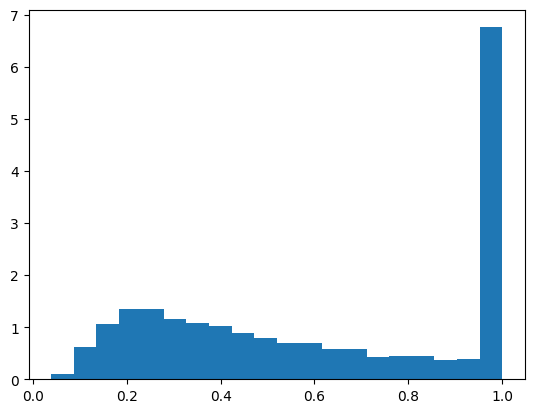

In [152]:
probs_lim = [np.min([1,p]) for p in probs]

plt.hist(probs_lim, bins=20, density=True)
#plt.yscale("log")
#plt.ylim([0.01,1])

In [165]:
print(R[0], R[M])
print(energy_local(R[0], R[M], alpha=0.15, kappa=2, beta=0.5))

[ 0.14800474 -0.1641085   0.28298481] [-0.26570262  0.28483992 -0.43464175]
-2.279713306756523


In [166]:
npl = np.linalg
def E_L(alpha, beta, kappa, vec1, vec2):
    
    r1=npl.norm(vec1)
    r2=npl.norm(vec2)
    r12=npl.norm(vec1-vec2)
    
    if r1==0:
        print("case 1: ", r1, r1)
        #vec1=0.01*np.ones(3)
        r1=0.1
        
    if r2 == 0:
        print("case 2: ", r2, r2)
        r2=0.1
    if r12 == 0:
        print("case 3: ", r12, r1, r2)
        r12=0.1
   # print(r12)

    
    u=1+alpha*r12
    v1 = vec1/r1 - vec2/r2
    v2 = 1/r12*(vec1-vec2)
    term3 = kappa*beta/u**2*np.dot(v1,v2)
    term1= (kappa-2)/r1 + (kappa-2)/r2 + 1/r12*(1-2*beta/u**2)
    term2= 2*beta*alpha/u**3-kappa**2-beta**2/u**4
    return term1 + term2 + term3

E_L(vec1=R[0], vec2=R[M],alpha=0.15, kappa=2, beta=0.5)

-2.2654552755472857

In [109]:
timestep = 0
walker = 0
sim_step_r1 = sim[timestep, walker, :]
sim_step_r2 = sim[timestep, walker+M, :]
e = energy_local(sim_step_r1, sim_step_r2, alpha=0.15, beta=0.5, kappa=2)

print(sim_step_r1)
print(sim_step_r2)
print(e)

[ 0.14800474 -0.1641085   0.28298481]
[-0.26570262  0.28483992 -0.43464175]
-2.279713306756523


In [110]:
N = 10000 # Todo: Change back to 30k
n = 1000
list_s = [0.1,1,10]

E_avg = []
E_std = []

for s_test in tqdm(list_s):
    simulation_s = metropolis_algorithm(R, N, s_test, alpha=0.15, beta=0.5, kappa=2, disable_tqdm=False)
    E_avg_s, E_std_s = energy_statistics(simulation_s, n, alpha=0.15, beta=0.5, kappa=2, disable_tqdm=False)
    E_avg.append(E_avg_s)
    E_std.append(E_std_s)

s = 0.1:


100%|██████████| 10000/10000 [00:34<00:00, 291.69it/s]


s = 1:


100%|██████████| 10000/10000 [00:34<00:00, 291.48it/s]


s = 10:


100%|██████████| 10000/10000 [00:34<00:00, 290.34it/s]


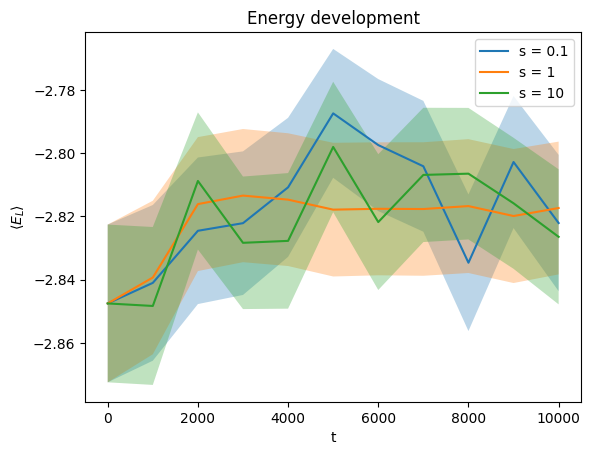

In [115]:
E_avg = np.array(E_avg)
E_std = np.array(E_std)

t = np.linspace(0,N,E_avg.shape[1])
for i in range(E_avg.shape[0]):
    plt.fill_between(t, E_avg[i]-E_std[i], E_avg[i]+E_std[i], alpha=0.3)
    plt.plot(t, E_avg[i], label=f"s = {list_s[i]}")
    
plt.title("Energy development")
plt.xlabel("t")
plt.ylabel(r"$\langle E_L \rangle$")
plt.legend()

#Todo: Look at the time, there is something wrong, maybe therefore weird standard deviation?

In [ ]:
plt.plot(np.arange())

In [119]:
E_avg = np.array(E_avg)
E_std = np.array(E_std)
print(pd.DataFrame({"s": list_s, "mean": E_avg[:,-1], "$\sigma$": E_std[:,-1]}))

      s      mean  $\sigma$
0   0.1 -2.808174  0.355044
1   1.0 -2.819642  0.365399
2  10.0 -2.789180  0.358577


# Problem b

In [ ]:
n

In [8]:
N_b = 1000
list_alpha = [0.0, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]

E_avg_alpha = []
E_std_alpha = []

for alpha in tqdm(list_alpha):
    simulation_a = metropolis_algorithm(R, N_b, s=1, alpha=alpha, beta=0.5, kappa=2, disable_tqdm=False)
    #metropolis_algorithm(R, num_trials=10000, s=10, alpha=0.15, beta=0.5, kappa=2)
    E_avg_a, E_std_a = energy_statistics(simulation_a, n, alpha=alpha, beta=0.5, kappa=2, display_tqdm=False)
    #E_avg_s, E_std_s = energy_statistics(sim, 1000, alpha=0.15, beta=0.5, kappa=2)
    E_avg_alpha.append(E_avg_a)
    E_std_alpha.append(E_std_a)

$\alpha$ = 0.0:


100%|██████████| 1000/1000 [00:09<00:00, 102.43it/s]


$\alpha$ = 0.1:


100%|██████████| 1000/1000 [00:09<00:00, 103.09it/s]


$\alpha$ = 0.2:


100%|██████████| 1000/1000 [00:09<00:00, 102.05it/s]


$\alpha$ = 0.3:


100%|██████████| 1000/1000 [00:09<00:00, 103.28it/s]


$\alpha$ = 0.4:


100%|██████████| 1000/1000 [00:09<00:00, 103.03it/s]


$\alpha$ = 0.5:


100%|██████████| 1000/1000 [00:09<00:00, 103.30it/s]


In [9]:
E_avg_alpha = np.array(E_std_alpha)
E_std_alpha = np.array(E_std_alpha)

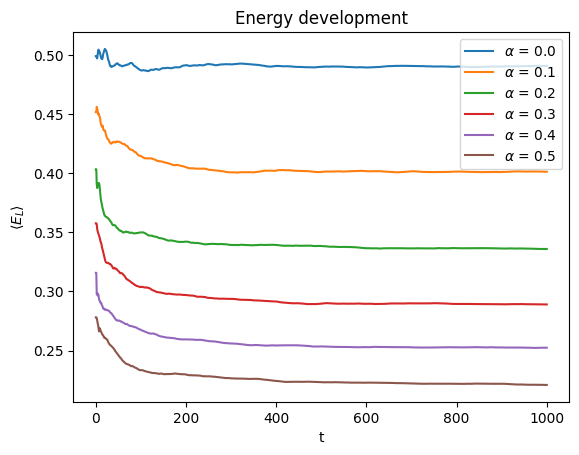

In [10]:
t_b = np.arange(1000+1)
for i in range(len(E_avg_alpha)):
    plt.plot(t_b, E_avg_alpha[i], label= rf"$\alpha$ = {list_alpha[i]}")
    
plt.title("Energy development")
plt.xlabel("t")
plt.ylabel(r"$\langle E_L \rangle$")
plt.legend()

# Problem c

In [66]:
def energy_statistics_c(simulation, equilibration_time, alpha=0.15, beta=0.5, kappa=2, disable_tqdm=False): # Todo: If change in energy_statistics function is made, it may be necessary to change it here as well
    energies = []
    num_simulation_steps = simulation.shape[0]
    e_0 = [energy_local(simulation[0,i], simulation[0,i+M], alpha=alpha, beta=beta, kappa=kappa) for i in range(M)]
    for time in tqdm(range(equilibration_time, num_simulation_steps), disable=disable_tqdm):
        energies_t = []
        for i in range(M):
            e_i = energy_local(simulation[time,i], simulation[time,i+M], alpha=alpha, beta=beta, kappa=kappa)
            energies_t.append(e_i)
        energies.append(energies_t)
    e_avg_t = np.mean(energies)
    e_var_t = np.std(energies)
    return np.array(e_avg_t), np.array(e_var_t)

In [68]:
N_c = 10000

In [54]:
M=10 #Todo: Change back to 300
n_equilibrium = 5000 # Todo: Choose appropriate value

list_alpha_c = np.linspace(0,0.5,50)

E_avg_alpha_c = []
E_std_alpha_c = []

for alpha in tqdm(list_alpha_c):
    simulation_a = metropolis_algorithm(R, N_c, s=1, alpha=alpha, beta=0.5, kappa=2, disable_tqdm=True)
    E_avg_a, E_std_a = energy_statistics_c(simulation_a, n_equilibrium, alpha=alpha, beta=0.5, kappa=2, disable_tqdm=True)
    E_avg_alpha_c.append(E_avg_a)
    E_std_alpha_c.append(E_std_a)
    
E_avg_alpha_c = np.array(E_avg_alpha_c)

100%|██████████| 50/50 [03:58<00:00,  4.78s/it]


Text(0.5, 1.0, 'Part c): Mean energy for different $\\alpha$')

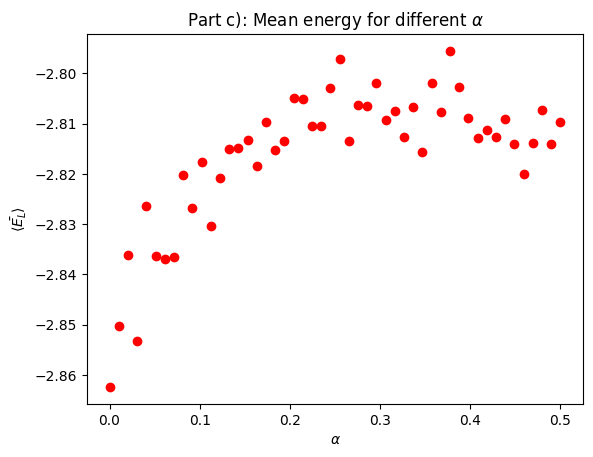

In [58]:
for i, alpha in enumerate(list_alpha_c):
    plt.plot(list_alpha_c[i], E_avg_alpha_c[i, -1], "ro", label = rf"$\alpha$ = {alpha}")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\langle \bar{E_{L}} \rangle$")
plt.title(r"Part c): Mean energy for different $\alpha$")

In [ ]:
#Todo: Plot sigma over alpha

# Problem d

In [69]:
alpha_optimal = 0.15 # Todo: Select optimal alpha from problem part c

list_kappa = np.linspace(1.7,2.2,50)

E_avg_kappa = []
E_std_kappa = []

for k in tqdm(list_kappa):
    simulation_k = metropolis_algorithm(R, N_c, s=1, alpha=alpha_optimal, beta=0.5, kappa=k, disable_tqdm=True)
    E_avg_k, E_std_k = energy_statistics_c(simulation_k, n_equilibrium, disable_tqdm=True)
    E_avg_kappa.append(E_avg_k)
    E_std_kappa.append(E_std_k)

E_avg_kappa = np.array(E_avg_kappa)

100%|██████████| 50/50 [03:27<00:00,  4.16s/it]


Text(0.5, 1.0, 'Part d): Mean energy for different $\\kappa$')

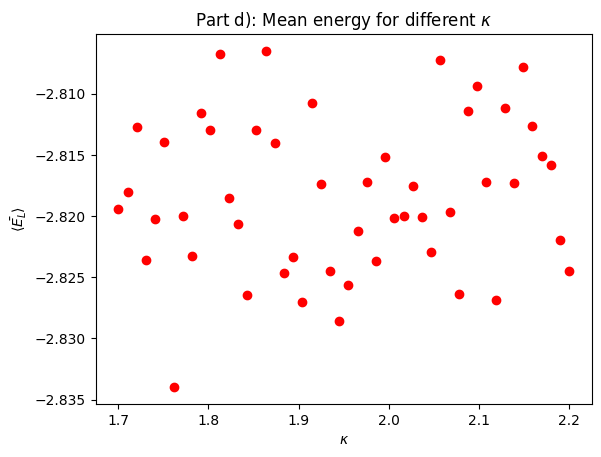

In [72]:
for i, k in enumerate(list_kappa):
    plt.plot(list_kappa[i], E_avg_kappa[i], "ro", label = rf"$\alpha$ = {k}")
plt.xlabel(r"$\kappa$")
plt.ylabel(r"$\langle \bar{E_{L}} \rangle$")
plt.title(r"Part d): Mean energy for different $\kappa$")

# Problem e

In [73]:
beta_e = 0.38
alpha_e = 0.18 
kappa_e = 1.85
simulation_e = metropolis_algorithm(R, N_c, s=1, alpha=alpha_e, beta=beta_e, kappa=kappa_e)
E_avg_e, E_std_e = energy_statistics_c(simulation_e, n_equilibrium, disable_tqdm=True)

100%|██████████| 10000/10000 [00:03<00:00, 2846.94it/s]


In [74]:
print(E_avg_e, E_std_e)

-2.823413388962978 0.36200612494147727


In [76]:
E_exp = -2.90338583

In [ ]:
#Todo: Include problem f (analytical calculation)

# Problem g

In [86]:
list_delta_t =[0.01, 0.05, 0.1, 0.2, 1.0]

metropolis_algorithm(R, 1000, 1, alpha_e, beta_e, kappa_e, use_FP = True, delta_t=1)

  0%|          | 0/1000 [00:00<?, ?it/s]


TypeError: greens_function() missing 1 required positional argument: 'delta_t'

Now implement the Fokker–Planck equation approach to VMC (FP-VMC), including the generalised Metropolis–Hasting accept/reject step to correct for the ∆τ truncation error.2 With that, run simulations using β = 0.38, α = 0.18 and κ = 1.85,
varying ∆τ = 0.01, 0.05, 0.1, 0.2, 1.0 to find the best value for ∆τ (i.e. one with the
lowest σE¯L
). Quote the value of ∆τ and the corresponding result for E¯
L and σE¯L
you obtain. Does it agree with the one obtained from your original VMC simulation?
How do the errors obtained compare using the same number of MC steps? Explain
this. (6 points)